In [ ]:
from cocpit.plotting_scripts import gewitter_functions
import cocpit
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import tqdm
from cocpit import config as config
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scikitplot.metrics import plot_roc as plot_roc

%load_ext autoreload
%autoreload 2


In [ ]:
plt_params = {
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
    "legend.title_fontsize": 14,
    "legend.fontsize": 12,
}
plt.rcParams["font.family"] = "serif"
plt.rcParams.update(plt_params)

In [ ]:
#  make predictions on each batch of images,
#  and concatenate the precitions across batches
p = cocpit.predictions.LoaderPredictions()
with torch.no_grad():
    for fold in range(config.KFOLD+1):
        model = p.load_model(fold)
        val_loader = p.load_val_loader(fold)
        for ((imgs, labels, paths), batch) in val_loader:
            b = cocpit.predictions.BatchPredictions(imgs, model)
            b.find_max_preds()
            b.top_k_preds(len(config.CLASS_NAMES))
            p.append_batch(b, paths, labels)
p.concatenate_loader_vars()
yhat = p.max_preds
y_validate = [i.item() for i in p.labels]

In [ ]:
# convert predictions into shape [n_samples, n_classes]
# where predictions are in order of class number (0,1,2)
# not highest to lowest probability
yhat_proba = np.zeros((len(p.topk_probs),len(config.CLASS_NAMES)))
for i in range(len(p.topk_probs)):
    for c in range(len(config.CLASS_NAMES)):
        yhat_proba[i, c] = p.topk_probs[i][np.where(np.array(p.topk_classes[i]) == c)[0][0]]

100%|██████████| 100/100 [00:02<00:00, 42.19it/s]


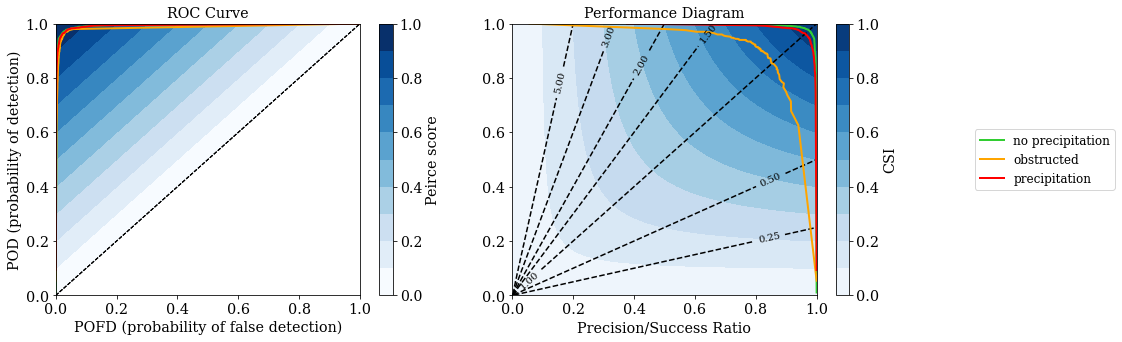

In [37]:
# plot performance diagram

threshs = np.linspace(0.0,1.0,100)
pofds = np.zeros((len(config.CLASS_NAMES), len(threshs)))
pods = np.zeros((len(config.CLASS_NAMES), len(threshs)))
srs = np.zeros((len(config.CLASS_NAMES), len(threshs)))

ax1, ax2 = gewitter_functions.make_performance_diagram_axis()
markerfacecolor = ['limegreen', 'orange', 'r']
for c, _ in enumerate(config.CLASS_NAMES):
    y_preds = yhat_proba[:,c]
    
    #for each threshold
    for i,t in enumerate(tqdm.tqdm(threshs)):
        #make a dummy array full of a wrong prediction
        if c == 0:
            y_preds_bi = np.ones(len(y_preds),dtype=int)
        else:
            y_preds_bi = np.zeros(len(y_preds),dtype=int)
        #find where the prediction is greater than or equal to the threshold
        idx = np.where(y_preds >= t)
        #set those indices to class label
        y_preds_bi[idx] = c
        #get the contingency table again 
        table = gewitter_functions.get_contingency_table(id=c, ol=np.array(p.labels), pl=np.array(y_preds_bi))
        
        #calculate pod, sr and csi 
        pofds[c,i] = gewitter_functions.get_pofd(table)
        srs[c,i] = gewitter_functions.get_sr(table)
        pods[c,i] = gewitter_functions.get_pod(table)
    ax2.plot(srs[c,:],pods[c,:],'-',color=markerfacecolor[c], markerfacecolor='w',lw=2, label=config.CLASS_NAMES[c])
    #ax2.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
    ax1.plot(pofds[c,:],pods[c,:],'-',color=markerfacecolor[c], markerfacecolor='w',lw=2, label=config.CLASS_NAMES[c])
    
    ax2.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))
    ax1.set_xlabel('POFD (probability of false detection)')
    ax1.set_ylabel('POD (probability of detection)')
    ax1.set_title('ROC Curve')
    ax1.set_ylim([0.0, 1.0])
    ax1.set_xlim([0.0, 1.0])
    ax1.plot([0, 1], [0, 1], 'k--', lw=1)
gewitter_functions.peirce_contour(ax1)

In [ ]:
def calc_roc(labels, preds):
    """Compute Receiver operating characteristic (ROC)
    and area under curve (AUC) as if binary classification.
    Loop through each class to be used as positive label"""
    fpr, tpr, roc_auc = {}, {}, {}
    for i, c in enumerate(config.CLASS_NAMES):
        fpr[i], tpr[i], _ = roc_curve(labels, preds[:, i], pos_label=i)
        roc_auc = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

def plot_roc(fpr, tpr, roc_auc):
    colors = ['limegreen', 'orange', 'r']
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    for i, c in enumerate(config.CLASS_NAMES):
        ax.plot(fpr[i], tpr[i], lw=2, color=colors[i],
                label=f'{c} (area = {1:0.2f})'
                        ''.format(c, roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_title('ROC Curves')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc='lower right')

fpr, tpr, roc_auc = calc_roc([i.item() for i in p.labels], yhat_proba)
plot_roc(fpr, tpr, roc_auc)

In [ ]:
# for c, _ in enumerate(config.CLASS_NAMES):
#     y_preds = yhat_proba[:,c]
#     pofds, pods = gewitter_functions.get_points_in_roc_curve(id=c, ol=np.array(p.labels), pl=np.array(y_preds), 
#                                 forecast_probabilities=y_preds, threshold_arg=np.linspace(0,1,100))
fig = plt.figure(figsize=(4.1,5))
threshs = np.linspace(0.0,1.0,100)
pofds = np.zeros((len(config.CLASS_NAMES), len(threshs)))
pods = np.zeros((len(config.CLASS_NAMES), len(threshs)))
for c, _ in enumerate(config.CLASS_NAMES):
    y_preds = yhat_proba[:,c]
    
    for i,t in enumerate(tqdm.tqdm(threshs)):
        #make a dummy array full of a wrong prediction
        if c == 0:
            y_preds_bi = np.ones(len(y_preds),dtype=int)
        else:
            y_preds_bi = np.zeros(len(y_preds),dtype=int)
        #find where the prediction is greater than or equal to the threshold
        idx = np.where(y_preds >= t)
        #set those indices to class label
        y_preds_bi[idx] = c
        #get the contingency table again 
        table = gewitter_functions.get_contingency_table(id=c, ol=np.array(p.labels), pl=np.array(y_preds_bi))

        # pofds[c,:], pods[c,:] = gewitter_functions.get_points_in_roc_curve(id=c, ol=np.array(p.labels), pl=np.array(y_preds_bi), 
        #                         forecast_probabilities=y_preds, threshold_arg=threshs)

        pofds[c,i] = gewitter_functions.get_pofd(table)
        pods[c,i] = gewitter_functions.get_pod(table)

    #set facecolor to white so you can copy/paste the image somewhere 
    fig.set_facecolor('w')

    #plot the ROC curve
    plt.plot(pofds[c,:],pods[c,:],color=colors[i],markerfacecolor='w',lw=2);


In [ ]:
# plot performance diagram

threshs = np.linspace(0.0,1.0,100)

pods = np.zeros((len(config.CLASS_NAMES), len(threshs)))
srs = np.zeros((len(config.CLASS_NAMES), len(threshs)))

ax = gewitter_functions.make_performance_diagram_axis()
markerfacecolor = ['limegreen', 'orange', 'r']
for c, _ in enumerate(config.CLASS_NAMES):
    y_preds = yhat_proba[:,c]
    
    #for each threshold
    for i,t in enumerate(tqdm.tqdm(threshs)):
        #make a dummy array full of a wrong prediction
        if c == 0:
            y_preds_bi = np.ones(len(y_preds),dtype=int)
        else:
            y_preds_bi = np.zeros(len(y_preds),dtype=int)
        #find where the prediction is greater than or equal to the threshold
        idx = np.where(y_preds >= t)
        #set those indices to class label
        y_preds_bi[idx] = c
        #get the contingency table again 
        table = gewitter_functions.get_contingency_table(len(config.CLASS_NAMES), id=c, ol=np.array(p.labels), pl=np.array(y_preds_bi))
        
        #calculate pod, sr and csi 
        pods[c,i] = gewitter_functions.get_pod(table)
        srs[c,i] = gewitter_functions.get_sr(table)
    ax.plot(srs[c,:],pods[c,:],'-',color=markerfacecolor[c], markerfacecolor='w',lw=2, label=config.CLASS_NAMES[c])
    ax.legend(loc='center left', bbox_to_anchor=(1.5, 0.5))


In [ ]:
import scikitplot as skplt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

class ROC():
    def __init__(self):
        self.fpr = {}
        self.tpr = {}
        self.roc_auc = {}
        
    def plot(self):
        fig, ax = plt.subplots(1, 1, figsize=(7,7))
        colors = ['limegreen', 'orange', 'r']
        for i, color in zip(range(len(config.CLASS_NAMES)), colors):
            ax.plot(
                self.fpr[i],
                self.tpr[i],
                color=color,
                lw=2,
                label="{}, AUC = {:0.2f}".format(
                    config.CLASS_NAMES[i], self.roc_auc[i]
                ),
            )

        ax.plot(
            self.fpr["macro"],
            self.tpr["macro"],
            linestyle="--",
            color='k',
            lw=2,
            label="macro-average ROC curve, AUC = {:0.2f}".format(
                self.roc_auc["macro"]
            ),
        )
        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.8, 1.0])
        ax.set_title('ROC Curves')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower right')

    def macro_average(self):
        """
        Compute the macro average scores for the ROC-AUC curves.
        """
        # Gather all FPRs
        all_fpr = np.unique(np.concatenate([self.fpr[i] for i in range(len(config.CLASS_NAMES))]))
        avg_tpr = np.zeros_like(all_fpr)

        # Compute the averages per class
        for i in range(len(config.CLASS_NAMES)):
            avg_tpr += np.interp(all_fpr, self.fpr[i], self.tpr[i])

        # Finalize the average
        avg_tpr /= len(config.CLASS_NAMES)

        # Store the macro averages
        self.fpr["macro"] = all_fpr
        self.tpr["macro"] = avg_tpr
        self.roc_auc["macro"] = auc(self.fpr["macro"], self.tpr["macro"])

    def score(self, labels, preds):
        for i, c in enumerate(config.CLASS_NAMES):
            self.fpr[i], self.tpr[i], _ = roc_curve(labels, preds[:, i], pos_label=i)
            self.roc_auc[i] = auc(fpr[i], tpr[i])
        
roc = ROC()
roc.score(p.labels, yhat)
roc.macro_average()
roc.plot()


In [ ]:
plot_roc(p.labels, yhat)

In [ ]:
pl = [i.item() for i in p.labels] #torch to value
wrong = sum(i != c for i, c in zip(pl, p.max_preds))
wrong/len(pl) 